In [7]:
import pandas as pd
import numpy as np

In [8]:
df = pd.read_csv("attributes_std.csv", index_col=0)
df.head()

,area,eccentricity,extent,GLCM Contrast,GLCM dissimilarity,GLCM homogeneity,GLCM ASM,GLCM energy,GLCM correlation,hist_r5,...,hist_v10,hist_v11,hist_v12,hist_v13,hist_v14,hist_v15,hist_v16,hist_v17,hist_v18,Weight
0,0.043333,-2.226854,0.363292,-1.542844,0.091402,0.646588,-0.157328,0.071042,-1.542844,-0.284688,...,1.955997,1.911448,0.967515,-0.302177,0.080586,1.363820,2.254121,-0.258405,-0.166822,1.66
1,0.049185,-2.203262,0.934037,0.913422,-1.606446,1.293831,1.704348,1.473114,0.913422,-0.284688,...,1.869296,1.859591,1.112211,-0.054567,0.080586,1.217367,2.369830,0.464176,-0.166822,1.66
2,0.043025,-2.231439,0.362645,-1.459200,-0.070608,0.710590,-0.076057,0.150221,-1.459200,-0.284688,...,2.048186,1.842658,0.988737,-0.201795,0.046530,1.281440,2.264640,-0.258405,-0.166822,1.66
3,0.051649,-2.219723,0.939462,0.426138,-0.348248,-0.847317,-1.104154,-1.280729,0.426138,-0.284688,...,1.906610,1.834191,1.150797,-0.034490,-0.021582,1.263134,2.464500,0.388115,-0.166822,1.66
4,0.042409,-2.227843,0.361352,-1.541941,0.098691,0.642377,-0.147996,0.080277,-1.541941,-0.284688,...,1.962582,1.907214,0.944363,-0.248640,0.160050,1.308900,2.212045,-0.144313,-0.166822,1.66


In [9]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, df.columns != 'Weight']

Y = df["Weight"]
print(np.shape(X))
print(np.shape(Y))
print(Y[0])

(12896, 91)
(12896,)
1.66


In [10]:
# TRAIN/TEST SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(10316, 91)
(10316,)
(2580, 91)
(2580,)


In [11]:
#HYPERPARAMETER GRID SEARCH
from keras import Sequential
from keras.layers import Dense, Dropout, Input
from keras.regularizers import L1
from keras.optimizers import Adam

num_classes = 6

model = Sequential()
model.add(Input(shape=(np.shape(X_train)[1],)))
model.add(Dense(64, activation='relu', kernel_regularizer=L1(0.001)))
model.add(Dense(32, activation='relu', kernel_regularizer=L1(0.001)))
model.add(Dense(16, activation='relu', kernel_regularizer=L1(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001),
    metrics=['mse'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,513 (33.25 KB)

 Trainable params: 8,513 (33.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

my_callbacks = [
    EarlyStopping(patience=5),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-5)
]

H = model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, Y_test),
    callbacks=my_callbacks)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 2.4216 - mse: 1.5012 - val_loss: 0.9747 - val_mse: 0.0816 - learning_rate: 0.0010
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0182 - mse: 0.1367 - val_loss: 0.8961 - val_mse: 0.0520 - learning_rate: 0.0010
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9268 - mse: 0.0962 - val_loss: 0.8277 - val_mse: 0.0393 - learning_rate: 0.0010
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8490 - mse: 0.0752 - val_loss: 0.7640 - val_mse: 0.0343 - learning_rate: 0.0010
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7801 - mse: 0.0654 - val_loss: 0.6980 - val_mse: 0.0286 - learning_rate: 0.0010
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7139 - mse: 0.0596 - val_loss: 0.6334 - val_mse: 0.0247 - learning_rate: 0.0010
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6489 - mse: 0.0554 - val_loss: 0.5728 - val_mse: 0.0243 - learning_rate: 0.0010
Epoch 8/100


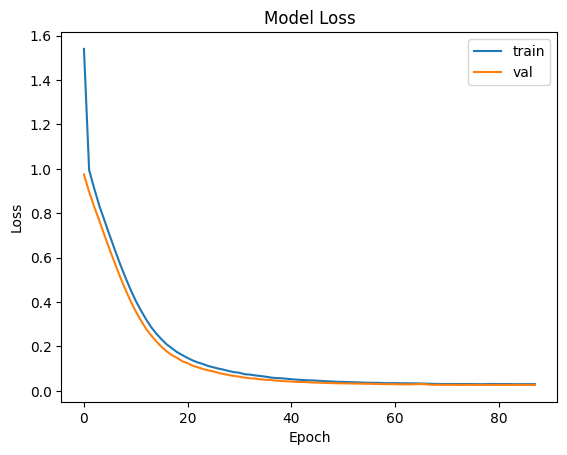

In [13]:
import matplotlib.pyplot as plt

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


In [14]:
import pickle

# Save models with pickle
with open('mlp.pkl', 'wb') as f:
    pickle.dump(model, f)

In [16]:
test_df = pd.read_csv("attributes_std_test.csv", index_col=0)
test_df.head()

X_test = test_df.loc[:, test_df.columns != 'Weight']
labels_test = test_df["Weight"]

In [17]:
predictions = model.predict(X_test, verbose=0)


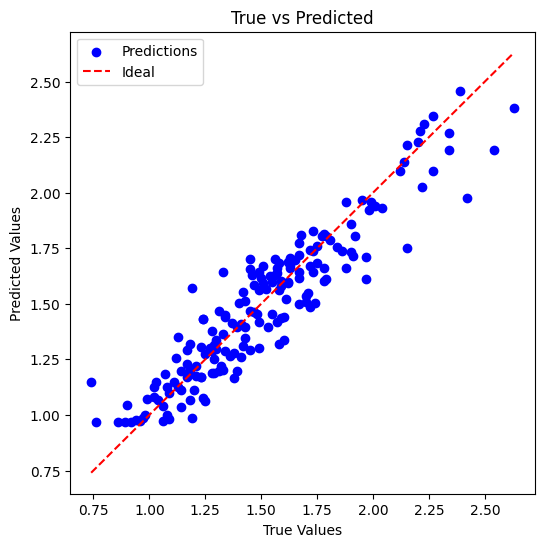

In [18]:
import matplotlib.pyplot as plt

# Scatter plot (True vs Predicted)
plt.figure(figsize=(6, 6))
plt.scatter(labels_test, predictions, color='blue', label='Predictions')
plt.plot([min(labels_test), max(labels_test)], [min(labels_test), max(labels_test)], 'r--', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(labels_test, predictions)
mse = mean_squared_error(labels_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(labels_test, predictions)
mape = np.mean(np.abs((np.array(labels_test) - np.array(predictions)) / np.array(labels_test))) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 0.10
Mean Squared Error (MSE): 0.02
Root Mean Squared Error (RMSE): 0.13
R-squared (R2) Score: 0.87
Mean Absolute Percentage Error (MAPE): 27.38%
